In [1]:
#torch imports
import torch
from torch import utils
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import WeightedRandomSampler, DataLoader

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tabulate import tabulate

#Using sklearn for the metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
#Necessary Formating for matplotlib to view confusion matrix in the end 
import matplotlib
font = {'weight' : 'bold',
        'family' : 'sans-serif',
        'size'   : 6}

matplotlib.rc('font', **font)

In [3]:
#Making sure it's running on the system's GPU for better performance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)
torch.cuda.empty_cache()

Running on cuda


In [4]:
#Data Located in Parent Folder, hence we change the current working directory
os.chdir('..')
path = os.getcwd() + '/AugmentedData/'
classes = os.listdir(path)
classes.sort()
print("Classes we are working with : ", classes)

Classes we are working with :  ['Ampulla of vater', 'Angiectasia', 'Blood - fresh', 'Blood - hematin', 'Erosion', 'Erythema', 'Foreign body', 'Ileocecal valve', 'Lymphangiectasia', 'Normal clean mucosa', 'Polyp', 'Pylorus', 'Reduced mucosal view', 'Ulcer']


In [5]:
#Create the tensor transforms
#As the data has already been augmented in the EDA, I'm choosing not to apply any complex transforms here
transform_general = transforms.Compose([transforms.ToTensor()])

#Load Dataset
data = datasets.ImageFolder(path, transform=transform_general)

# Split into train/val/test sets:
#80% of the full dataset is used for training
train_len = int(len(data)*0.8)
trainData, remaining = random_split(data, [train_len, len(data) - train_len])
#testing data will comprise of 80% of the remaining data
test_len = int(len(remaining)*0.8)
testData, valData = random_split(remaining, [test_len, len(remaining) - test_len])

#Printing Sizes of Each split up dataset
print("Train set : ", len(trainData))
print("Val set : ", len(valData))
print("Test set : ", len(testData))

Train set :  18186
Val set :  910
Test set :  3637


The classes are still quiet imbalanced after augmentation as well. Thus I will use a weighted sampler when loading the datsets in order to achieve a more accurate prediction.

In [6]:
#Calculating Class weights 

# Extract classes:
train_classes = [trainData.dataset.targets[i] for i in trainData.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[trainData.dataset.targets[i]] for i in trainData.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(trainData)*2), replacement=True)

In [7]:
# Torch dataloaders:
batch_size = 32
#To visualise
dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))
print(dataloaders.dataset)

#Training Data
train = DataLoader(trainData, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train)*batch_size)

#Validation Data
val = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val)*batch_size)

#Testing Data
test = DataLoader(testData, batch_size=batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test)*batch_size)

The total number of images is: 1137
Dataset ImageFolder
    Number of datapoints: 22733
    Root location: c:\Users\Divya\Desktop\Kvasir-Capsule-ML-Project/AugmentedData/
    StandardTransform
Transform: Compose(
               ToTensor()
           )
The number of images in a training set is: 36384
The number of images in a validation set is: 928
The number of images in a test set is: 3648


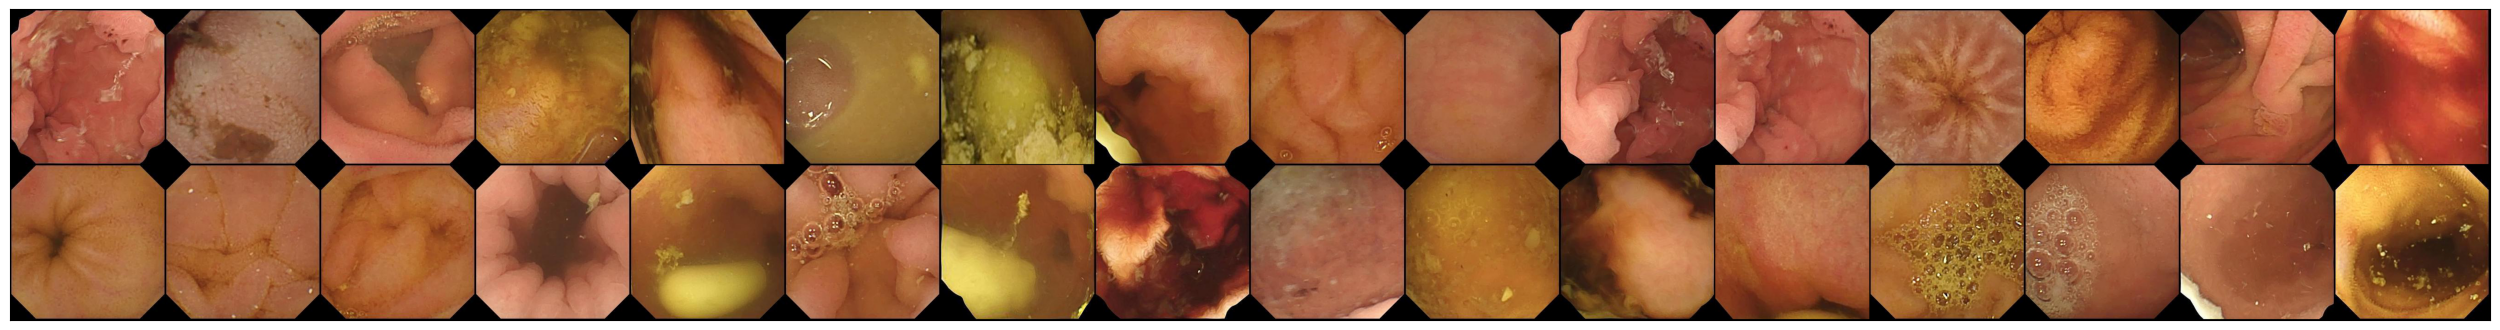

In [8]:
#Plot of the Data in a single batch
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (32,32))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train)

***Creating a CNN Model from scratch using pytorch***

In [9]:
#Creating a simple CNN architechture
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    #Defining a sequential model layers
    self.c1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=5, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.c2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.c3 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, padding=1, stride=2),
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
    self.drop = nn.Dropout()
    self.fc = nn.Linear(in_features = 25600, out_features = 14)

  def forward(self, x):
    output = self.c1(x)
    output = self.c2(output)
    output = self.drop(output)
    output = self.c3(output)
    #or nn.Flatten()
    output = output.reshape(output.size(0), -1)
    # Each img : (336 x 336)
    # Formula : w' = ((W - F + 2P)/S) + 1
    output = self.fc(output)
    return output


In [10]:
#Define model
model = SimpleCNN().to(device)
print(model)
#View Model Summary
from torchsummary import summary
summary(model, (3, 336, 336))

SimpleCNN(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=25600, out_features=14, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 166, 166]        --
|    └─Conv2d: 2-1                       [-1, 16, 332, 332]        1,216
|    └─LeakyReLU: 2-2                    [-1, 16, 332, 332] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 166, 166]        --
|    └─Conv2d: 2-1                       [-1, 16, 332, 332]        1,216
|    └─LeakyReLU: 2-2                    [-1, 16, 332, 332]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 166, 166]        --
├─Sequential: 1-2                        [-1, 32, 82, 82]          --
|    └─Conv2d: 2-4                       [-1, 32, 164, 164]        4,640
|    └─LeakyReLU: 2-5                    [-1, 32, 164, 164]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 82, 82]          --
├─Dropout: 1-3                           [-1, 32, 82, 82]          --
├─Sequential: 1-4                        [-1, 64, 20, 20]          --
|    └─Conv2d: 2-7                       [-1, 64, 41, 41]          18,496
|    └─LeakyReLU: 2-8                    [-1, 64, 41, 41]          --
|    └─AvgPool2d: 2-9                    [-1, 64, 20, 20]          --
├─Lin

In [11]:
#Defining the Loss Criteria and Optimization Algorithm for this model
lossCriteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
#Visulaize the Results (Functions called later on)
def plot_acc_curve(train_accuracy, validation_accuracy):

  plt.plot(train_accuracy, color='green')
  #plt.plot(validation_accuracy, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')

  plt.show()

def plot_loss_curve(train_losses, validation_losses):
  plt.plot(train_losses, color='green')
  #plt.plot(validation_losses, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.title('Training Losses')

  plt.show()

In [13]:
#Training and Validation of Model
def train_validate_model(e, train, val, model, optimizer, lossCriteria):

  train_losses = []
  train_accuracy_list = []

  val_losses = []
  val_accuracy_list = []

  # Initialize the prediction and label lists(tensors)
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

  for epoch in range(e):

    run_loss = 0.0
    val_loss = 0.0

    #TRAINING
    model.train()
    correct = 0
    total = 0

    for img, class_ in train:

      img, class_ = img.to(device), class_.to(device)

      optimizer.zero_grad()
      preds = model(img)

      loss = lossCriteria(preds, class_)

      loss.backward()
      optimizer.step()

      run_loss += loss.item()

      _, predicted = preds.max(1)
      total += class_.size(0)
      correct += predicted.eq(class_).sum().item()

    #training accuracy calculation per epoch
    accuracy_train = correct * 100. / total
    train_accuracy_list.append(accuracy_train)

    #training loss calculation per epoch
    train_loss = run_loss / len(train.sampler)
    train_losses.append(train_loss)

    #VALIDATION (within loop)

    #making sure the model is not learning from this chunk of the Data
    with torch.no_grad():
      model.eval()
      correct_ = 0
      total_ = 0

      for img, class_ in val:

        img, class_ = img.to(device), class_.to(device)

        preds_ = model(img)
        loss = lossCriteria(preds_, class_)
        val_loss += loss.item()

        _, predicted = preds_.max(1)
        total_ += class_.size(0)
        correct_ += predicted.eq(class_).sum().item()

        #Append batch prediction results
        predlist = torch.cat([predlist, predicted.view(-1).cpu()])
        lbllist = torch.cat([lbllist, class_.view(-1).cpu()])

    #validation accuracy calculation per epoch
    accuracy_val = correct_ * 100. / total_
    val_accuracy_list.append(accuracy_val)

    #validation loss calculation per epoch
    val_loss = val_loss / len(test.sampler)
    val_losses.append(val_loss)


    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(epoch, train_loss, accuracy_train, val_loss, accuracy_val))
  
  #Generate Confusion matrix
  conf_mat_val = confusion_matrix(lbllist.numpy(), predlist.numpy())
  print("The Val confusion matrix\n", conf_mat_val)

  #return results
  return model, train_losses, train_accuracy_list, val_losses, val_accuracy_list, conf_mat_val


In [14]:
#Model testing
def testing_model(test, model):

    test_losses = []
    test_accuracy_list = []

    predlist__ =torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist__ =torch.zeros(0,dtype=torch.long, device='cpu')
    t_loss = 0.0
    
    #making sure the model is not learning from this chunk of the Data
    with torch.no_grad():
        model.eval()
        correct_ = 0
        total_ = 0

        for img, class_ in test:

            img, class_ = img.to(device), class_.to(device)

            preds_ = model(img)
            loss = lossCriteria(preds_, class_)
            t_loss += loss.item()

            _, predicted = preds_.max(1)
            total_ += class_.size(0)
            correct_ += predicted.eq(class_).sum().item()

            #Append batch prediction results
            predlist__ = torch.cat([predlist__, predicted.view(-1).cpu()])
            lbllist__ = torch.cat([lbllist__, class_.view(-1).cpu()])

        #testing accuracy
        accuracy_test = correct_ * 100. / total_
        test_accuracy_list.append(accuracy_test)

        #testing loss
        t_loss = t_loss / len(test.sampler)
        test_losses.append(t_loss)

    #Generate Confusion matrix
    conf_mat_test = confusion_matrix(lbllist__.numpy(), predlist__.numpy())
    print("The Test confusion matrix\n ", conf_mat_test)

    return test_losses, test_accuracy_list, conf_mat_test


In [15]:
#Calling the training function and checking time taken for computation
t0 = time.time()
model, train_losses, train_accuracy, val_losses, val_accuracy, conf_matrix_val = train_validate_model(20, train, val, model, optimizer, lossCriteria)
time_elapsed = time.time() - t0

Epoch: 0 	Training Loss: 0.0267 	Training Accuracy: 71.7585 	Validation Loss: 0.0059 	Validation Accuracy: 76.0440
Epoch: 1 	Training Loss: 0.0098 	Training Accuracy: 89.6761 	Validation Loss: 0.0047 	Validation Accuracy: 79.2308
Epoch: 2 	Training Loss: 0.0064 	Training Accuracy: 93.2805 	Validation Loss: 0.0038 	Validation Accuracy: 85.2747
Epoch: 3 	Training Loss: 0.0045 	Training Accuracy: 95.1941 	Validation Loss: 0.0035 	Validation Accuracy: 85.4945
Epoch: 4 	Training Loss: 0.0041 	Training Accuracy: 95.6560 	Validation Loss: 0.0033 	Validation Accuracy: 89.3407
Epoch: 5 	Training Loss: 0.0031 	Training Accuracy: 96.8355 	Validation Loss: 0.0033 	Validation Accuracy: 88.0220
Epoch: 6 	Training Loss: 0.0028 	Training Accuracy: 96.9674 	Validation Loss: 0.0032 	Validation Accuracy: 89.5604
Epoch: 7 	Training Loss: 0.0025 	Training Accuracy: 97.3304 	Validation Loss: 0.0041 	Validation Accuracy: 86.1538
Epoch: 8 	Training Loss: 0.0023 	Training Accuracy: 97.5173 	Validation Loss: 0.

Time Elapsed for training the model : 2740.6308274269104 seconds


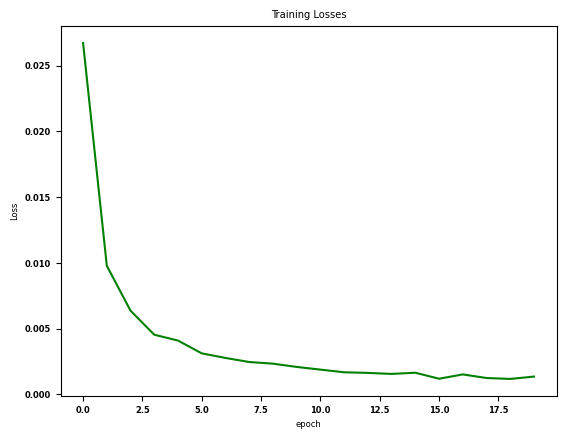

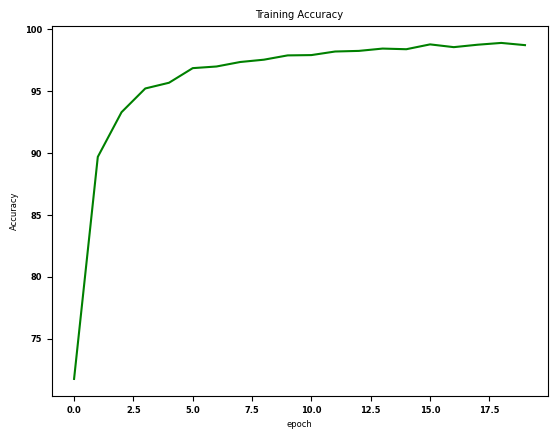

In [16]:
print("Time Elapsed for training the model : {} seconds".format(time_elapsed))

#Visualize training phase
plot_loss_curve(train_losses, val_losses)
plot_acc_curve(train_accuracy, val_accuracy)

In [17]:
#Testing Model
print("Model Training results : ")
test_loss, test_accuracy, conf_mat_test = testing_model(test, model)
print("Overall Loss : ", test_loss)
print("Overall Test Accuracy : ", test_accuracy)

Model Training results : 
The Test confusion matrix
  [[134   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0 139   1   0   2   4   1   0   2   0   1   0   0   3]
 [  0   2 165   0   0   0   0   1   0   0   0   0   0   0]
 [  1   0   0 175   2   0   0   0   0   0   0   0   0   0]
 [  0   7   0   0 129   3   5   1  12   3   0   0   0   1]
 [  0   0   0   0   0 153   0   0   0   0   0   0   0   2]
 [  0   5   2   0   5   1 153   0   5   1   0   1   0   2]
 [  0   0   2   0   0   0   0 577   0  51   0   1  28   0]
 [  0   5   0   0   6   5   3   0 149   0   0   0   0   1]
 [  0   1   0   0   0   0   1  58   0 562   0  19  25   0]
 [  0   0   0   0   0   0   1   0   0   0 169   0   0   0]
 [  0   0   0   0   0   0   0   6   0  15   0 203   0   0]
 [  0   0   0   0   0   0   0  11   0  17   0   0 448   0]
 [  0   0   0   0   4   0   2   0   1   0   0   0   0 141]]
Overall Loss :  [0.014417716891704301]
Overall Test Accuracy :  [90.65163596370635]


*Inference*

The Saturated curves show that the model was stabalizing and further training on more epochs would not be necessary as the model would not continue to learn much from this

In [18]:
#Evaluation
#Function to calculate the F1 score
def get_f1_score(conf_matrix, i):
    TP, FP, TN, FN = 0, 0, 0, 0

    for j in range(len(conf_matrix)):
        if (i == j):
            TP += conf_matrix[i, j]
            tmp = np.delete(conf_matrix, i, 0)
            tmp = np.delete(tmp, j, 1)

            TN += np.sum(tmp)
        else:
            if (conf_matrix[i, j] != 0):

                FN += conf_matrix[i, j]
            if (conf_matrix[j, i] != 0):

                FP += conf_matrix[j, i]

    recall = TP / (FN + TP)
    precision = TP / (TP + FP)
    f1_score = 2 * 1/(1/recall + 1/precision)

    return f1_score

#function to retrieve class accuracies for each class
def per_class_accuracies(conf_mat):
  class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
  print("Per class accuracy :\n", class_accuracy)
  return class_accuracy

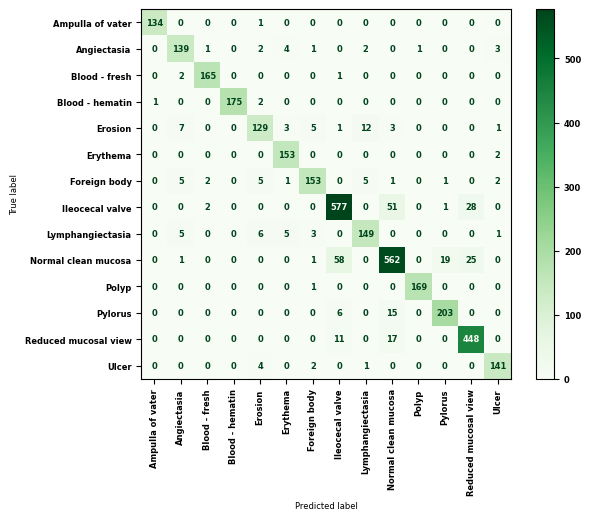

In [19]:
#Display Confusion matrix with final results
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_test, display_labels=classes)
disp.plot(cmap='Greens', xticks_rotation="vertical", )

In [20]:
#Alternative Metrics to determine models performance
class_accuracies = per_class_accuracies(conf_mat_test)

f1Scores = []
for i in range(len(classes)-1):
    f1Scores.append(get_f1_score(conf_mat_test, i))
print("The f1 scores for Induvidual classes are :\n", f1Scores)

Per class accuracy :
 [99.25925926 90.8496732  98.21428571 98.31460674 80.1242236  98.70967742
 87.42857143 87.5569044  88.16568047 84.38438438 99.41176471 90.625
 94.11764706 95.27027027]
The f1 scores for Induvidual classes are :
 [0.9925925925925927, 0.891025641025641, 0.9763313609467454, 0.991501416430595, 0.832258064516129, 0.9532710280373833, 0.8973607038123167, 0.8789032749428789, 0.8816568047337278, 0.8547528517110264, 0.9941176470588236, 0.90625, 0.9170931422722621]


In [21]:
#Metrics View
headers = ['Class', 'Accuracy', 'F1 Score']
print(tabulate(zip(classes, class_accuracies, f1Scores), headers=headers, floatfmt=".4f"))

Class                   Accuracy    F1 Score
--------------------  ----------  ----------
Ampulla of vater         99.2593      0.9926
Angiectasia              90.8497      0.8910
Blood - fresh            98.2143      0.9763
Blood - hematin          98.3146      0.9915
Erosion                  80.1242      0.8323
Erythema                 98.7097      0.9533
Foreign body             87.4286      0.8974
Ileocecal valve          87.5569      0.8789
Lymphangiectasia         88.1657      0.8817
Normal clean mucosa      84.3844      0.8548
Polyp                    99.4118      0.9941
Pylorus                  90.6250      0.9062
Reduced mucosal view     94.1176      0.9171


In [23]:
#saving the model for future training purposes 
torch.save(model, 'model.pth')